# Combating Gerrymandering Through Non-Geographic Visualizations
### Using models of distortion to emphasize partisanship in map drawing
Xavier Adomatis

## Data Background
- Historical data (2004-2020) drawn from wikipedia via wayback machine scraping. 
    - Neither Cook or National Journal's paid subscriptions offer data repositories inclusive of redrawn districts.
- 2022 projections data breakdown:
    - 45 states drawn from Dave's Redistricting (semi-open source)
    - 5 states drawn from 538 and reverse engineered
        - FL due to recency of passage
        - WV and KY due to data gaps
        - NH and MO due to maps not being finalized
- Issues with data quality preclude API usage

## Data Quirks
- Incomplete maps: MO and NH 
    - Data draws on the highest passed/not vetoed proposals
- Legally fluctuating maps: NY and KS
    - Both maps are headed to state supreme courts in the next two weeks for validity
- Temporary maps: NC
    - Map will be invalid in the 2024 cycle

## Methodology for Fairness
#### Compare the expected value of Congressional Representation with the state's share of voters
- States with neutral ratings have better porportionality
- Porportionality can mean two things:
    - A state can emphasize competitive districts (i.e. New Hampshire's 2012-2020 map)
    - A state can cut polarized districts porportional to its population (i.e. Maine's 2012-2020 map)
    - A more polarized state can mix the methods, like Iowa
- Using expected value in a model is better than other metrics (median seat and wasted votes) because it accounts for the steep jump between PVIs
    - If an R+5 state like Texas had 38 R+5 congressional districts, it would score fairly under all other metrics; however, this would result in 80% of the Congressional seats being Republican, excluding much of the 47.5% of the Democrating population
- PVI is the fundamental basis point because it ignores incumbent advantages but still accounts for Congressional outperformance of presidential parties (especially for the GOP)

## Methodology for Predictions
- Because we have the data, we can machine learn on the last 9 Congressional cycles (~4,000 elections) as the training set and test based on the 2022 map
- if we train on wave years (2006, 2008, 2010, 2014, and 2018) we have a narrower training set but are still roughly able to capture new relationships with PVI

## Prediction Methodology Explained

#### Raw Averages on waves
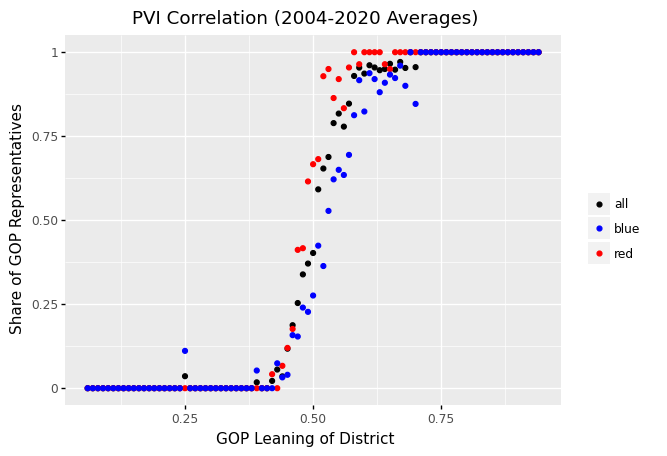
- All-years averaged is basically contiuous
- Wave models are significantly less so, with R+9's more likely to be Democratic than R+7's
- Mildly Democratic districts are more immune to waves than GOP mildly districts
- Machine learning is necessary to account for these differences

#### Logit on waves
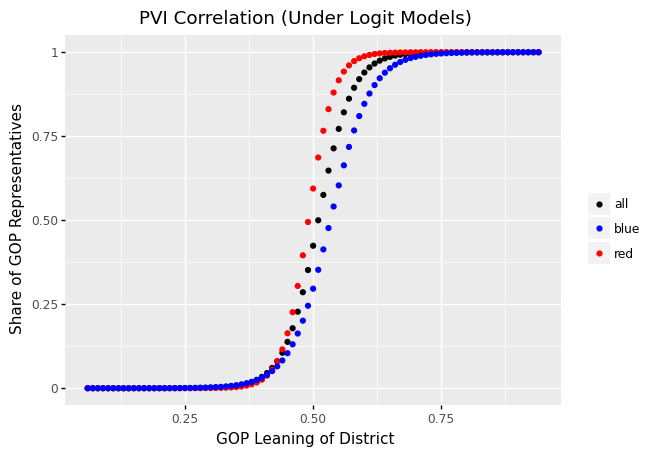
- Accounts for the disporportionate impact of waves on 'likely' districts, especially for GOP leaning districts
- Ideally this would be tested on SVMs as well, but probability extraction seems to be impossible

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import warnings
warnings.filterwarnings("ignore")
hexagon = "M0,-2.3094010768L2,-1.1547005384 2,1.1547005384 0,2.3094010768 -2,1.1547005384 -2,-1.1547005384Z"
converter = "/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/app_building/app_data/converter.csv"
state_data = "/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/app_building/app_data/state_data.csv"
state_coords = "/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/app_building/app_data/cartogram_coords.csv"
hourglass_coords = "/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/app_building/app_data/hourglass_coords.csv"
district_data = "/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/app_building/app_data/district_data.csv"
cv = pd.read_csv(converter)
st = pd.read_csv(state_data)
sc = pd.read_csv(state_coords)
hc = pd.read_csv(hourglass_coords)
dd = pd.read_csv(district_data)
#create a function to change the probabilities based on a partisan wave

def call_wave(wave):
    '''Call a model by function name (to be used within a larger function)
    
    Args:
        A string that refers to the model name. Options are Linear SVC, SVC, and Logistic Regression 
    
    Returns:
        A model as a function for later use
    '''
    #create an if/else to identify the possible models
    if wave == "Republican":
        col = cv["logit_red"]
    elif wave == "Democratic":
        col = cv["logit_blue"]
    #return a string if it fails- it will block the function from applying
    else:
        col = cv["logit_all"]
    index = cv[["metric"]]
    index["prob"] = col
    return index

st = st.merge(sc, how="left")

## Cartogram

In [2]:
#build out the chart
df = st
slider = alt.binding_range(min=2004, max=2022, step=2)
select_year = alt.selection_single(name="Election", fields=['year'],
                                   bind=slider, init={'year': 2004})
#build the chare
st_cart = alt.Chart(df).mark_point().encode(
    alt.X('X',axis=None),
    alt.Y('Y',axis=None),
    alt.Text('ST'),
    alt.Color('porp_loss', scale=alt.Scale(scheme='redblue'), legend=alt.Legend(title="Porportion not Represented")),
    tooltip = [alt.Tooltip('porp_text',title='Porportion Lost'),
               alt.Tooltip('dist_text',title='District Deficit')
              ]
)
#inser labels
st_cart_labs = alt.Chart(df).mark_text(align='center').encode(
    alt.X('X'),
    alt.Y('Y'),
    alt.Text('ST'),
).properties(title='Severity of Partisan Misrepresentation')
#display
Cartogram = alt.layer(st_cart, st_cart_labs).configure_axis(grid=False).configure_view(strokeWidth=0).configure_point(size=250,shape=hexagon,filled=True).add_selection(select_year).transform_filter(select_year)

In [3]:
Cartogram

alt.LayerChart(...)

- Highlights states with suprisingly high levels of distortion, especially those with few districts
- Allows users to see their own state's misrepresentation

## Bubble Chart

In [4]:
df["dist_loss"] = abs(df["dist_loss"])

#slider
slider = alt.binding_range(min=2004, max=2022, step=2)
select_year = alt.selection_single(name="Election", fields=['year'],
                                   bind=slider, init={'year': 2004})
#create a bubble chart
selection = alt.selection_single();
Bubble = alt.Chart(df).mark_point(filled=True).encode(
    alt.X('metric', scale=alt.Scale(zero=False), title='Porportion Republican'),
    alt.Y('porp_loss', scale=alt.Scale(zero=False), title='Porportion of Population not Represented'),
    alt.Size('dist_loss', legend=alt.Legend(title="Amount of Seats Effected")),
    alt.Order('dist_loss', sort='descending'),
    alt.Color('porp_loss', scale=alt.Scale(scheme='redblue'), legend=alt.Legend(title="Porportion not Represented")),
    tooltip = [alt.Tooltip('ST',title='State'),
               alt.Tooltip('porp_text',title='Porportion Lost'),
               alt.Tooltip('dist_text',title='District Deficit')],
    ).add_selection(selection).properties(title='Severity of Partisan Misrepresentation').add_selection(select_year).transform_filter(select_year)

In [5]:
Bubble

alt.Chart(...)

- Highlights impact of distortion when weighted as Congressional districts impacted
- Shows distortion is concentrated in small red states but biggest district shifts are in blue states

## Wave Prediction Models
- Plots that use logit predictions to examine possible outcomes on the 2022 map
- Also works on historical datasets; test runs have shown approximate outcomes
    - Mostly due to model training on those years

In [6]:
def get_viz(year,wave,chart):
    #build out the chart
    df = st[st["year"] == year]
    df["ST"] = df["ST"]
    #state cartogram
    #build the chart
    st_cart = alt.Chart(df).mark_point().encode(
        alt.X('X',axis=None),
        alt.Y('Y',axis=None),
        alt.Text('ST'),
        alt.Color('porp_loss', scale=alt.Scale(scheme='redblue'), legend=alt.Legend(title="Porportion not Represented")),
        tooltip = [alt.Tooltip('porp_text',title='Porportion Lost'),
                   alt.Tooltip('dist_text',title='District Deficit')
                  ]
    )
    #inser labels
    st_cart_labs = alt.Chart(df).mark_text(align='center').encode(
        alt.X('X'),
        alt.Y('Y'),
        alt.Text('ST'),
    ).properties(title='Severity of Partisan Misrepresentation')
    #display
    cart = alt.layer(st_cart, st_cart_labs).configure_axis(grid=False).configure_view(strokeWidth=0).configure_point(size=250,shape=hexagon,filled=True)
    #create a bubble chart
    selection = alt.selection_single();
    bubble = alt.Chart(df).mark_point(filled=True).encode(
        alt.X('metric', scale=alt.Scale(zero=False), title='Porportion Republican'),
        alt.Y('porp_loss', scale=alt.Scale(zero=False), title='Porportion of Population not Represented'),
        alt.Size('dist_loss', legend=alt.Legend(title="Amount of Seats Effected")),
        alt.Order('dist_loss', sort='descending'),
        alt.Color('porp_loss', scale=alt.Scale(scheme='redblue'), legend=alt.Legend(title="Porportion not Represented")),
        tooltip = [alt.Tooltip('ST',title='State'),
                   alt.Tooltip('porp_text',title='Porportion Lost'),
                   alt.Tooltip('dist_text',title='District Deficit')
                  ]
    ).add_selection(selection).properties(title='Severity of Partisan Misrepresentation')
    #set up for wave sensitive results
    conv = call_wave(wave)
    dist = dd[dd["year"] == year]
    dist = dist.merge(conv, how="left")
    #create the amounts chart for the Majority Bar
    amounts = pd.DataFrame(dist.prob.value_counts()).reset_index()
    amounts.columns = ["prob_GOP","num_dist"]
    amounts["quantity"] = amounts["prob_GOP"] * amounts["num_dist"]
    expec_GOP = amounts["quantity"].sum()
    expec_dem = 435 - expec_GOP
    d = {'Expected Seats' : [expec_dem, expec_GOP], 'Party' : ["Dem","GOP"]}
    expec = pd.DataFrame(data = d, index=None)
    #output an associated phrase
    party_control = str(np.where(expec_GOP > expec_dem, "Republicans", "Democrats"))
    num = np.where(expec_GOP > expec_dem, expec_GOP, expec_dem)
    num_seats = str(num.round())
    phrase = party_control + " are expected to control the house with a majority of " + num_seats.rstrip(".0")  + " seats"
    #output majority control chart
    cd_scale = [0,50,100,150,175,200,218,235,260,285,335,385,435]
    maj = alt.Chart(expec).mark_bar().encode(
        alt.X('sum(Expected Seats)',axis=alt.Axis(values=cd_scale),title="Expected Partisan Control"),
        alt.Color('Party', scale=alt.Scale(range=["blue","red"]))
    ).properties(title=phrase)
    #format data for median seat chart
    dist = dist.sort_values("metric",ascending=False).reset_index()
    dist["X"] = hc["X"]
    dist["Y"] = hc["Y"]
    hg = alt.Chart(dist).mark_point().encode(
        alt.X('X',axis=None),
        alt.Y('Y',axis=None),
        #alt.Text('ST'),
        alt.Color('prob', scale=alt.Scale(range=["darkblue","blue","grey","red","darkred"]), legend=alt.Legend(title="Probability of GOP Representation")),
        tooltip = [alt.Tooltip('ST#',title='District'),
                   alt.Tooltip('PVI',title='PVI'),
                   alt.Tooltip('prob',title='Prob GOP'),
                  ]
    ).configure_point(size=15,shape=hexagon,filled=True).configure_view(strokeWidth=0)
    if chart == "Cartogram":
        return cart
    elif chart == "Bubble":
        return bubble
    elif chart == "Median":
        return hg
    else:
        return maj

In [7]:
get_viz(2022,"All","Majority")

alt.Chart(...)

In [8]:
get_viz(2022,"All","Median")

alt.Chart(...)

In [9]:
get_viz(2022,"Democratic","Majority")

alt.Chart(...)

In [10]:
get_viz(2022,"Democratic","Median")

alt.Chart(...)

In [11]:
get_viz(2022,"Republican","Majority")

alt.Chart(...)

In [12]:
get_viz(2022,"Republican","Median")

alt.Chart(...)

Questions? Advice?